# Predicting Customer Loyalty Score Using ML

#### Context

Our client, a grocery retailer, hired a market research consultancy to append market level customer loyalty information to the database. However, only around 50% of the client’s customer base could be tagged, thus the other half did not have this information present.

The overall aim of this work is to accurately predict the loyalty score for those customers who could not be tagged, enabling our client a clear understanding of true customer loyalty, regardless of total spend volume - and allowing for more accurate and relevant customer tracking, targeting, and comms.

To achieve this, we looked to build out a predictive model that will find relationships between customer metrics and loyalty score for those customers who were tagged, and use this to predict the loyalty score metric for those who were not.


#### Actions

We firstly needed to compile the necessary data from tables in the database, gathering key customer metrics that may help predict loyalty score, appending on the dependent variable, and separating out those who did and did not have this dependent variable present.

As we are predicting a numeric output, we test with `Linear Regression` modelling approach.

### Linear Regression with Scikit-Learn

We utilize the `scikit-learn` library within Python to model our data using Linear Regression. The process is divided into four key sections:

- **Data Import**
- **Data Preprocessing**
- **Model Training**
- **Performance Assessment**

### Import required packages

In [5]:
import pandas as pd
import pickle

### Importing and overview of the data

In [7]:
#Importing the data
loyalty_scores = pd.read_excel("retail_store_database.xlsx", sheet_name= "loyalty_scores")
customer_details = pd.read_excel("retail_store_database.xlsx", sheet_name= "customer_details")
transactions = pd.read_excel("retail_store_database.xlsx", sheet_name= "transactions")

#### Overview of the data

In [9]:
loyalty_scores.head()

,customer_id,customer_loyalty_score
0,104,0.587
1,69,0.156
2,525,0.959
3,181,0.418
4,796,0.570


In [10]:
customer_details.head()

,customer_id,distance_from_store,gender,credit_score
0,74,3.38,F,0.59
1,524,4.76,F,0.52
2,607,4.45,F,0.49
3,343,0.91,M,0.54
4,322,3.02,F,0.63


In [11]:
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


### Creating the customer level dataset

The data in the `loyalty scores` and `customer details` are in the customer level, while in the `transactions` data set, the data is at the transaction-id level. Hence, the `transactions` data shall be aggregated to customer-id level so that it can be merged with `loyalty scores` and `customer details` to create a single dataframe.

In [13]:
#Merging customer_details and loyalty_scores
data_for_regression = pd.merge(customer_details, loyalty_scores, how= "left", on= "customer_id")

#Aggregating the transactions data
sales_summary = transactions.groupby("customer_id").agg({"sales_cost": "sum",
                                                         "num_items": "sum", 
                                                         "transaction_id": "count",
                                                         "product_area_id": "nunique"}).reset_index()
sales_summary.columns = ["customer_id", "total_sales", "total_items", "transactions_count", "product_area_count"]
sales_summary["average_basket_value"] = sales_summary["total_sales"]/sales_summary["transactions_count"]

#Merging data_for_regression and sales_summary
data_for_regression = pd.merge(data_for_regression, sales_summary, how= "inner", on= "customer_id")

In [14]:
data_for_regression.shape

(870, 10)

### Segregating the modelling data and scoring data

For regression modelling, the data without null values is selected from `data_for_regression`, while for regression scoring data with null values is selected.

In [16]:
regression_modelling = data_for_regression.loc[data_for_regression["customer_loyalty_score"].notna()]
regression_scoring = data_for_regression.loc[data_for_regression["customer_loyalty_score"].isna()]

In [17]:
Number_of_unique_customers = data_for_regression.shape[0]
Customers_having_loyalty_scores = regression_modelling.shape[0]
Customers_loyalty_scores_to_predict = regression_scoring.shape[0]
print(f"Number_of_unique_customers = {Number_of_unique_customers}\nCustomers_having_loyalty_scores = {Customers_having_loyalty_scores}\nCustomers_loyalty_scores_to_predict = {Customers_loyalty_scores_to_predict}")

Number_of_unique_customers = 870
Customers_having_loyalty_scores = 400
Customers_loyalty_scores_to_predict = 470


### Saving Regression modelling and Regression scoring files

In [19]:
pickle.dump(regression_modelling, open("retail_store_regression_modelling.p", "wb"))
pickle.dump(regression_scoring, open("retail_store_regression_scoring.p", "wb"))

### Import required packages for Regression

In [21]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

### Importing and filtering data

Here `data_for_model` is retrived using `pickle`. Alternatively, we can directly use `regression_modelling` directly instead of loading the data via `pickle`. 

In [23]:
data_for_model = pickle.load(open("retail_store_regression_modelling.p", "rb"))

#Drop unncessary columns
data_for_model.drop("customer_id", axis=1, inplace= True)

#Shuffle data
data_for_model = shuffle(data_for_model, random_state= 42)

### Dealing with missing values

To deal with the missing attributes we have three options:
1. get rid of the missing data points
2. get rid of the whole attribute
3. set the value to some value (0, mean, median, most frequent)

In [25]:
#Calculating the missing values
credit_score_median = data_for_model["credit_score"].median()
distance_from_store_median = data_for_model["distance_from_store"].median()
gender_mode = data_for_model["gender"].mode()[0]

#Filling the missing values
data_for_model.fillna(value={"credit_score": credit_score_median,
                             "distance_from_store": distance_from_store_median,
                             "gender": gender_mode}, inplace=True)

### Dealing with ouliers

In [27]:
outlier_investigation = data_for_model.describe()

In [28]:
outlier_columns = ["distance_from_store", "total_sales", "total_items"]

#### Box plot approach

In [30]:
for column in outlier_columns:
    lower_quantile = data_for_model[column].quantile(0.25)
    upper_quantile = data_for_model[column].quantile(0.75)
    interquantile = upper_quantile - lower_quantile
    interquantile_extended = interquantile * 2
    min_border = lower_quantile - interquantile_extended
    max_border = upper_quantile + interquantile_extended
    
    outliers = data_for_model[(data_for_model[column] < min_border) | (data_for_model[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")
    
    data_for_model.drop(outliers, inplace= True)

2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
0 outliers detected in column total_items


### Split input & output variables

In [32]:
X = data_for_model.drop(["customer_loyalty_score"], axis= 1)
y = data_for_model["customer_loyalty_score"]

### Split data into Train & Test 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 42)

### Dealing with categorical variables

#### List of columns with categorical variables

In [37]:
categorical_vars = ["gender"] 

#### Categorical variable transformer - OneHoTEncoder

In [39]:
one_hot_encoder = OneHotEncoder(sparse_output= False, drop= "first") 

`sparse_output= False` will return an array, rather than an object, which is called a sparse matrix.
d`drop` ensures that one column from each of the categorical variable value column is dropped which avoids multicollinearity among the variables

#### Training and transforming the categorical variables

In [42]:
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

#### Getting the feature names

In [44]:
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

#### (1) Creating a dataframe of categorical values as boolean 

In [46]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns= encoder_feature_names)

#### (2) Concatinating the encoded dataframe to the `X_train`

In [48]:
X_train = pd.concat([X_train.reset_index(drop= True), X_train_encoded.reset_index(drop= True)], axis= 1) 

`reset_index` is set to `true` so that when concatenating, this will ensure that no rows are not aligned as if they are, else we might end up with missing values.
`axis= 1` means we are concatinating on columns and not on rows

#### (3) Dropping the categorical variable columns

In [51]:
X_train.drop(categorical_vars, axis= 1, inplace= True)

#### Applying the above steps (1 to 3) on the `X_test` dataframe 

In [53]:
X_test_encoded = pd.DataFrame(X_test_encoded, columns= encoder_feature_names) #creating a dataframe of categorical values as boolean with their respective column names
X_test = pd.concat([X_test.reset_index(drop= True), X_test_encoded.reset_index(drop= True)], axis= 1) 
X_test.drop(categorical_vars, axis= 1, inplace= True)

In [54]:
X_test.head()

,distance_from_store,credit_score,total_sales,total_items,transactions_count,product_area_count,average_basket_value,gender_M
0,4.62,0.47,3296.51,320,51,5,64.637451,0.0
1,1.92,0.64,1992.51,305,53,5,37.594528,0.0
2,4.38,0.47,343.41,70,12,4,28.617500,0.0
3,1.96,0.60,1678.45,355,46,4,36.488043,0.0
4,2.52,0.50,1967.39,316,55,5,35.770727,0.0


#### Saving the One Hot Encoder

In [56]:
pickle.dump(one_hot_encoder, open("regression_ohe.p", "wb"))

### Feature Selection - Recursive Feature Elimination Cross Validation (RFECV)

In [58]:
features_list = pd.DataFrame(X_train.columns)

regressor = LinearRegression()
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X_train, y_train)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

Optimal number of features: 6


In [59]:
feature_boolean = pd.DataFrame(feature_selector.get_support())
feature_summary = pd.concat([features_list, feature_boolean], axis= 1)
feature_summary.columns = ["feature_name", "boolean"]
feature_summary

,feature_name,boolean
0,distance_from_store,True
1,credit_score,True
2,total_sales,False
3,total_items,True
4,transactions_count,False
5,product_area_count,True
6,average_basket_value,True
7,gender_M,True


### Saving Feature Selection

In [61]:
feature_selector_RFECV = pickle.dump(feature_selector, open("regression_feature_selector_RFECV.p", "wb"))

#### Visualizing the Feature Importance

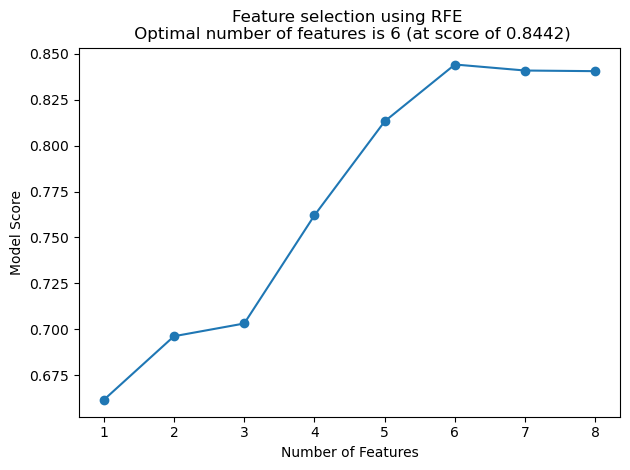

In [63]:
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker= "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']), 4)})")
plt.tight_layout()
plt.show()

### Model Training

In [65]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

### Model Assessment

#### Predict on the test setres.mean()

In [68]:
y_pred = regressor.predict(X_test)

#### Calculate R-squared

R-Squared is a metric that shows the percentage of variance in our output variable y that is being explained by our input variable(s) x. It is a value that ranges between 0 and 1, with a higher value showing a higher level of explained variance. Another way of explaining this would be to say that, if we had an r-squared score of 0.8 it would suggest that 80% of the variation of our output variable is being explained by our input variables - and something else, or some other variables must account for the other 20%.

To calculate r-squared, we use the following code where we pass in our predicted outputs for the test set (y_pred), as well as the actual outputs for the test set (y_test)

In [70]:
r_squared = r2_score(y_test, y_pred)
print(f"r_squared = {r_squared}")

r_squared = 0.8016177309444464


#### Cross Validation

An even more powerful and reliable way to assess model performance is to utilise Cross Validation.

Instead of simply dividing our data into a single training set, and a single test set, with Cross Validation we break our data into a number of “chunks” and then iteratively train the model on all but one of the “chunks”, test the model on the remaining “chunk” until each has had a chance to be the test set.

The result of this is that we are provided a number of test set validation results - and we can take the average of these to give a much more robust & reliable view of how our model will perform on new, un-seen data!

In the code below, we put this into place. We first specify that we want 4 “chunks” and then we pass in our regressor object, training set, and test set. We also specify the metric we want to assess with, in this case, we stick with r-squared.

Finally, we take a mean of all four test set results.

In [72]:
cv = KFold(n_splits= 4, shuffle= True, random_state= 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv= cv, scoring= "r2")
cv_scores_mean = cv_scores.mean()
print(f"cv_scores_mean = {cv_scores_mean}")

cv_scores_mean = 0.8477632268736278


#### Calculate Adjusted R-Squared

When applying Linear Regression with multiple input variables, the r-squared metric on it’s own can end up being an overinflated view of goodness of fit. This is because each input variable will have an additive effect on the overall r-squared score. In other words, every input variable added to the model increases the r-squared value, and never decreases it, even if the relationship is by chance.

Adjusted R-Squared is a metric that compensates for the addition of input variables, and only increases if the variable improves the model above what would be obtained by probability. It is best practice to use Adjusted R-Squared when assessing the results of a Linear Regression with multiple input variables, as it gives a fairer perception the fit of the data.

In [74]:
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1- (1-r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f"adjusted_r_squared = {adjusted_r_squared}")

adjusted_r_squared = 0.7841134130866034


#### Extract Model Coefficients

In [76]:
coefficients = pd.DataFrame(regressor.coef_)
input_variable_names = pd.DataFrame(X_train.columns)
summary_stats = pd.concat([input_variable_names, coefficients], axis= 1)
summary_stats.columns = ["input_variables", "coefficients"]
summary_stats

,input_variables,coefficients
0,distance_from_store,-0.182909
1,credit_score,-0.014609
2,total_items,0.000772
3,product_area_count,0.053651
4,average_basket_value,0.002729
5,gender_M,0.023718


The coefficient value for each of the input variables, along with that of the intercept would make up the equation for the line of best fit for this particular model (or more accurately, in this case it would be the plane of best fit, as we have multiple input variables).

For each input variable, the coefficient value we see above tells us, with everything else staying constant how many units the output variable (loyalty score) would change with a one unit change in this particular input variable.

To provide an example of this - in the table above, we can see that the distance_from_store input variable has a coefficient value of -0.1829. This is saying that loyalty_score decreases by 0.1829 (or 18.29% as loyalty score is a percentage, or at least a decimal value between 0 and 1) for every additional mile that a customer lives from the store. This makes intuitive sense, as customers who live a long way from this store, most likely live near another store where they might do some of their shopping as well, whereas customers who live near this store, probably do a greater proportion of their shopping at this store…and hence have a higher loyalty score!

#### Extract Model Intercept

In [79]:
regressor_y_intercept = regressor.intercept_
print(f"regressor_y_intercept = {regressor_y_intercept}")

regressor_y_intercept = 0.32753471467956435


### Saving the regressor

In [81]:
pickle.dump(regressor, open("linear_regression_model.p", "wb"))

## Predicting the missing loyalty scores

### Import customers data for scoring 

In [84]:
to_be_scored = pickle.load(open("retail_store_regression_scoring.p", "rb"))
customer_id = pd.DataFrame(to_be_scored["customer_id"])
to_be_scored.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transactions_count,product_area_count,average_basket_value
6,1,4.78,F,0.66,NaN,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,NaN,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,NaN,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,NaN,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,NaN,3448.59,370,49,5,70.379388


### Drop unused columns

From the model training with Recursive Feature Elimination Cross Validation, out of 8 features 2 features namely `total_sales` and `transactions_count` were of less important and hence we drop these two features. As we are predicting the `customer_loyalty_score` itself we drop this feature along with `customer_id`. 

In [86]:
to_be_scored.drop(["customer_id", "customer_loyalty_score", "total_sales", "transactions_count"], axis= 1, inplace= True)

### Dealing with missing values

In [88]:
#Calculating the missing values
credit_score_median = data_for_model["credit_score"].median()
distance_from_store_median = data_for_model["distance_from_store"].median()
gender_mode = data_for_model["gender"].mode()[0]

#Filling the missing values
to_be_scored.fillna(value={"credit_score": credit_score_median,
                             "distance_from_store": distance_from_store_median,
                             "gender": gender_mode}, inplace=True)

### Import model and model objects

In [90]:
regressor = pickle.load(open("linear_regression_model.p", "rb"))
one_hot_encoder = pickle.load(open("regression_ohe.p", "rb"))

### Applying One Hot Encoding

In [92]:
categorical_vars = ["gender"]
encoder_vars_array = one_hot_encoder.transform(to_be_scored[categorical_vars])
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)
encoder_vars_df = pd.DataFrame(encoder_vars_array, columns= encoder_feature_names)
to_be_scored = pd.concat([to_be_scored.reset_index(drop= True), encoder_vars_df.reset_index(drop= True)], axis= 1) 
to_be_scored.drop(categorical_vars, axis= 1, inplace= True)

In [93]:
to_be_scored.head()

,distance_from_store,credit_score,total_items,product_area_count,average_basket_value,gender_M
0,4.78,0.66,424,5,78.048824,0.0
1,3.49,0.38,253,5,64.160000,0.0
2,14.91,0.68,335,5,71.122340,0.0
3,0.25,0.62,267,5,48.473125,1.0
4,4.74,0.58,370,5,70.379388,0.0


### Making predictions

In [95]:
loyalty_score_predictions = regressor.predict(to_be_scored)
loyalty_score_predictions = pd.DataFrame(loyalty_score_predictions)
print(f"Number of loyalty score predicted = {loyalty_score_predictions.shape[0]}")

Number of loyalty score predicted = 470


In [96]:
loyalty_score_predictions = pd.concat([customer_id.reset_index(drop= True), loyalty_score_predictions.reset_index(drop= True)], axis= 1)
loyalty_score_predictions.columns = ["customer_id", "predicted_loyalty_score"]